# Exploring Dandiset 001375: Septum GABA disruption with DREADDs

**Notebook generated with the assistance of AI**  
Please use caution when interpreting the code or results. Review and validate code before using it for critical analysis.

---

This notebook provides an overview and interactive introduction to [Dandiset 001375](https://dandiarchive.org/dandiset/001375/0.250406.1855), which contains high-density extracellular electrophysiology recordings from mice in a GABAergic septal disruption paradigm. The data are in NWB format and are organized by subject and session. 

## What you will find:
- Summary of the scientific context and dataset contents
- Listing and exploration of the NWB files
- Guided walkthrough of how to load, inspect, and visualize:
  - Subject/session/trial metadata
  - Electrode group and channel structure
  - Spike-sorted units and spike counts
  - Raw traces and neural signals from selected channels
  - Lap (trial)-aligned spike raster and per-lap firing rates
- Practical plotting code to jumpstart your own analyses

---

## Required Packages

The following packages are required (assume these are installed):
- `dandi`
- `pynwb`
- `h5py`
- `remfile`
- `numpy`
- `pandas`
- `matplotlib`

---

Let's get started by exploring the assets in this Dandiset!

In [1]:
# Import required packages
from dandi.dandiapi import DandiAPIClient
import pandas as pd
import numpy as np
import remfile
import h5py
import matplotlib.pyplot as plt
import pynwb

## 1. Dandiset Overview and File Listing

We'll use the DANDI API to explore the files in this Dandiset and obtain direct URLs for remote streaming.

In [2]:
# List all NWB files in the Dandiset

dandiset_id = "001375"
dandiset_version = "0.250406.1855"  # latest at the time of notebook generation

client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List NWB assets
assets = list(dandiset.get_assets_by_glob("*.nwb"))

nwb_files_df = pd.DataFrame([{
    "path": asset.path,
    "size_GB": asset.size / 1e9,
    "download_url": asset.download_url
} for asset in assets])

nwb_files_df[["path", "size_GB"]]

,path,size_GB
0,sub-MS13B/sub-MS13B_ses-20240725T190000_ecephy...,54.970746
1,sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12...,69.445662
2,sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ar...,69.788881


**NWB files in this Dandiset:**

| File | Size (GB) |
|------|---------|
| sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb | 54.97 |
| sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12781w8_ecephys.nwb | 69.45 |
| sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ardad2_ecephys.nwb  | 69.79 |

We'll proceed to explore the structure and contents of the first file as a representative example.

## 2. Inspect File Metadata, Subject, and Session Info

We'll stream the file directly using `remfile`/`h5py` and open with `pynwb`. This avoids downloading the file locally.

We'll also extract subject demographics and a summary of the session and behavioral trials.

In [3]:
# Stream and open the NWB file using pynwb (first NWB file as example)

# Select a file for exploration
nwb_asset = next(dandiset.get_assets_by_glob("sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb"))
url = nwb_asset.download_url

# Open remote NWB file
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# --- Extract subject and session info ---
subject_info = {
    'subject_id': nwb.subject.subject_id,
    'species': nwb.subject.species,
    'sex': nwb.subject.sex,
    'age': nwb.subject.age,
    'description': nwb.subject.description
}
session_info = {
    'session_description': nwb.session_description,
    'session_start_time': str(nwb.session_start_time),
    'identifier': nwb.identifier
}

# --- Extract trials info ---
if hasattr(nwb, 'trials'):
    trials_df = nwb.trials.to_dataframe()
    n_trials = trials_df.shape[0]
    trial_durations = trials_df['stop_time'] - trials_df['start_time']
    avg_duration = trial_durations.mean()
    example_trials = trials_df.head(5)
else:
    n_trials = 0
    avg_duration = None
    example_trials = None

print("Subject info:", subject_info)
print("Session info:", session_info)
print(f"Number of trials: {n_trials}")
if avg_duration is not None:
    print(f"Mean trial duration (s): {avg_duration:.2f}")
    print("\nFirst 5 trials:")
    print(example_trials)

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Subject info: {'subject_id': 'MS13B', 'species': 'Mus musculus', 'sex': 'M', 'age': 'P90D', 'description': 'medial septum DREADD to suppress GABA interneurons'}
Session info: {'session_description': 'mouse running laps in virtual hallway', 'session_start_time': '2024-07-25 19:00:00-07:00', 'identifier': 'MS13B'}
Number of trials: 387
Mean trial duration (s): 12.30

First 5 trials:
    start_time  stop_time
id                       
0     4.323800  16.929833
1    16.963067  28.414333
2    28.447100  39.402833
3    39.435833  50.027033
4    50.059667  63.064467


**Summary of Subject and Session**

- **Subject ID:** MS13B
- **Species:** Mus musculus (House mouse)
- **Sex:** Male
- **Age:** P90D (90 days)
- **Subject Description:** medial septum DREADD to suppress GABA interneurons

- **Session Description:** Mouse running laps in virtual hallway
- **Session Start:** 2024-07-25 19:00:00 -0700
- **Trials (laps):** 387, avg. duration ≈ 12.3 seconds

Example of the first 5 trials:

| Start (s) | Stop (s) |
|-----------|----------|
| 4.32      | 16.93    |
| 16.96     | 28.41    |
| 28.45     | 39.40    |
| 39.44     | 50.03    |
| 50.06     | 63.06    |


## 3. Exploring Electrode Groups and Channel Structure

Let's examine how many electrodes (channels) are present, how they're grouped (shanks), and the metadata provided for each.

Total electrodes: 256
Electrode groups and counts:
group_name
shank1    128
shank2    128
Name: count, dtype: int64

Locations (unique): ['unknown']



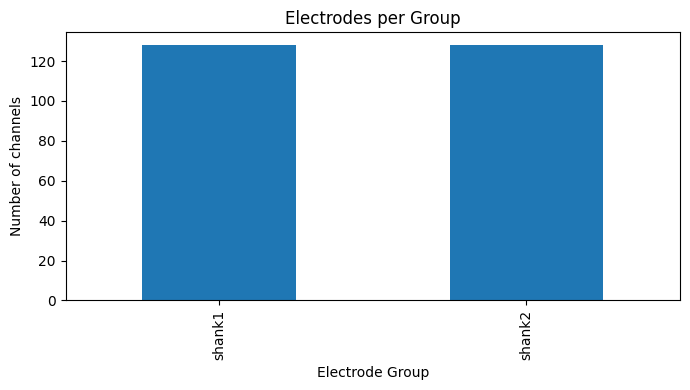

,group_name,location
id,,
0,shank1,unknown
1,shank1,unknown
2,shank1,unknown
3,shank1,unknown
4,shank1,unknown


In [4]:
# Extract electrode/channel structure

edf = nwb.electrodes.to_dataframe()
channel_count = edf.shape[0]
group_counts = edf['group_name'].value_counts()
locations = edf['location'].unique()

print(f"Total electrodes: {channel_count}")
print(f"Electrode groups and counts:\n{group_counts}\n")
print(f"Locations (unique): {locations}\n")

# Plot: channels per group
plt.figure(figsize=(7,4))
group_counts.plot(kind='bar')
plt.ylabel('Number of channels')
plt.xlabel('Electrode Group')
plt.title('Electrodes per Group')
plt.tight_layout()
plt.show()

# Show first 6 electrodes, their group and location
edf[['group_name', 'location']].head()

- **256 electrodes** organized evenly into two "shanks."
- Metadata about electrode group, but per-electrode anatomical location is "unknown."
- Device is described as a 128-channel silicon probe (2 probes/shanks total).

The plot confirms equal channel distribution across shanks.

## 4. Spike-Sorted Units: Counts and Quality

Next, let's explore the spike sorting results: number of units, their spike counts, and the distribution across units.

**Note:** To get the number of spikes for each unit, we use the `.spike_times` column of the units dataframe (which contains the actual spike times as an array for each unit).

Total spike-sorted units: 33

Spike counts for first 5 units:
id
1     18960
2    100435
3    278061
4     36265
5     39735
Name: spike_times, dtype: int64 

Mean number of spikes per unit: 63935.3
Median number of spikes per unit: 39735.0


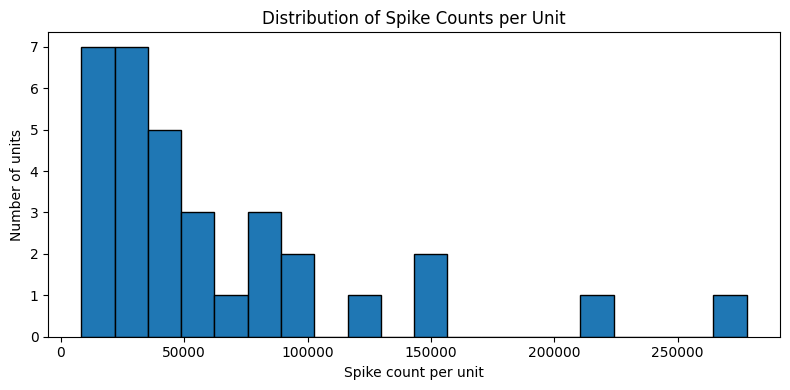

In [5]:
# Access and plot spike-sorted units

units_df = nwb.units.to_dataframe()
unit_count = units_df.shape[0]

# Calculate spike counts per unit (using .spike_times array for each unit)
if 'spike_times' in units_df.columns:
    spikes_per_unit = units_df['spike_times'].apply(len)
else:
    spikes_per_unit = pd.Series([0]*unit_count, index=units_df.index)  # fallback, shouldn't be triggered here

print(f"Total spike-sorted units: {unit_count}\n")
print("Spike counts for first 5 units:")
print(spikes_per_unit.head(), "\n")
print(f"Mean number of spikes per unit: {spikes_per_unit.mean():.1f}")
print(f"Median number of spikes per unit: {spikes_per_unit.median():.1f}")

plt.figure(figsize=(8,4))
plt.hist(spikes_per_unit, bins=20, edgecolor='k')
plt.xlabel('Spike count per unit')
plt.ylabel('Number of units')
plt.title('Distribution of Spike Counts per Unit')
plt.tight_layout()
plt.show()

- **33 spike-sorted units** detected in this session.
- Spike counts are variable (many units around 20k–60k spikes; some as high as ~278k).
- The histogram above illustrates spike count dispersion, suggesting a diverse set of activity levels.

## 5. Visualizing Raw Neural Traces

Let's extract a short snippet from the raw traces for a small subset of channels, providing an overview of the data structure and quality.

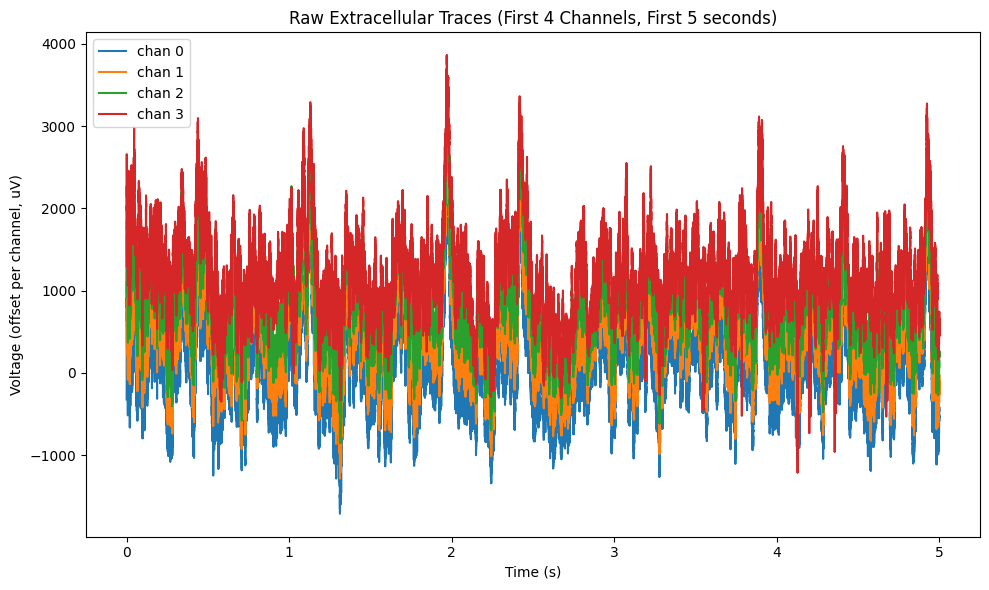

In [6]:
# Plot first 5 seconds of first 4 channels

ts = nwb.acquisition['time_series']
rate = ts.rate
n_channels = ts.data.shape[1]

duration_s = 5
n_samples = int(duration_s * rate)
subset = ts.data[:n_samples, :4]  # shape: [samples, channels]
t = np.arange(n_samples) / rate

plt.figure(figsize=(10,6))
offset = 400
for i in range(4):
    plt.plot(t, subset[:,i] + i*offset, label=f'chan {i}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (offset per channel, uV)')
plt.title('Raw Extracellular Traces (First 4 Channels, First 5 seconds)')
plt.legend()
plt.tight_layout()
plt.show()

This plot demonstrates the quality and structure of the extracellular signal across several channels—a crucial first step when starting any new analysis.

Each trace is offset for clarity. You can see field/fluctuation activity and spikes clearly.

## 6. Spike Raster: Lap-Aligned Neural Activity

Let's visualize spike rasters for all units during the first lap (trial)—a standard approach for linking neural firing to behavior.

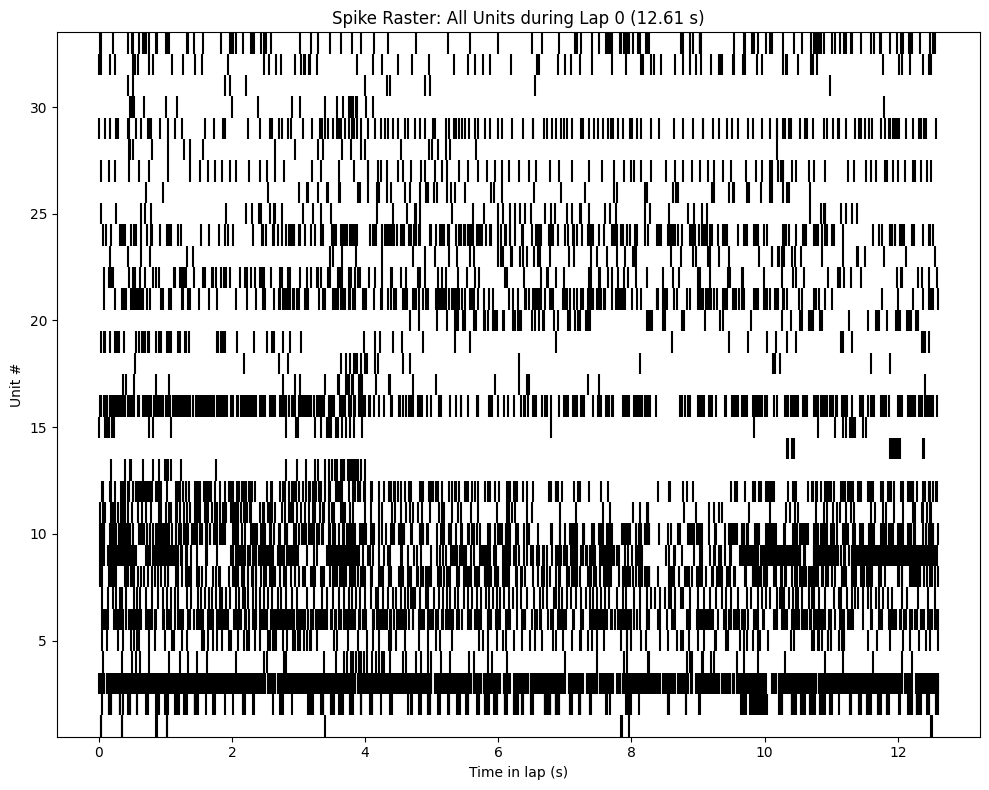

In [7]:
# Raster for all units during first lap trial

trial = nwb.trials.to_dataframe().iloc[0]
start, stop = trial['start_time'], trial['stop_time']
unit_ids = list(units_df.index)

# Gather spike times for each unit during this lap
lap_spikes = [np.array(times[(times >= start) & (times < stop)]) for times in units_df['spike_times']]

plt.figure(figsize=(10,8))
for i, spikes in enumerate(lap_spikes):
    plt.vlines(spikes - start, i+0.5, i+1.5, color='k')
plt.xlabel('Time in lap (s)')
plt.ylabel('Unit #')
plt.title(f'Spike Raster: All Units during Lap 0 ({stop-start:.2f} s)')
plt.ylim(0.5, len(unit_ids)+0.5)
plt.tight_layout()
plt.show()

Each row represents one unit (neuron), and each vertical tick is a spike.
This plot demonstrates how to align spike data to behavioral epochs ("trial" or "lap").

Such visualizations can be adapted for any time window, trial, or subset of units.

## 7. Firing Rate Modulation Across Laps

Now, let's compute and plot the per-lap firing rate for a few units, illustrating the relationship between behavior and neural spiking.

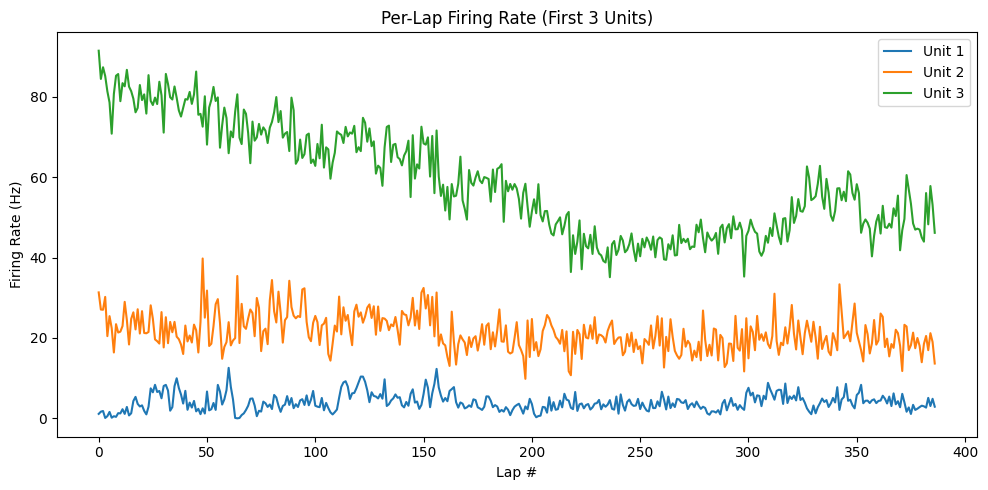

In [8]:
# Compute per-lap firing rates for first 3 units

unit_indices = units_df.index[:3]  # first 3 units

per_lap_rates = []
trials = nwb.trials.to_dataframe()
for i, trial in trials.iterrows():
    start, stop = trial['start_time'], trial['stop_time']
    rates = []
    for u in unit_indices:
        spikes = units_df.loc[u, 'spike_times']
        count = np.sum((spikes >= start) & (spikes < stop))
        rate = count / (stop - start)
        rates.append(rate)
    per_lap_rates.append(rates)
per_lap_rates = np.array(per_lap_rates)

plt.figure(figsize=(10,5))
for i, u in enumerate(unit_indices):
    plt.plot(per_lap_rates[:,i], label=f'Unit {u}')
plt.xlabel('Lap #')
plt.ylabel('Firing Rate (Hz)')
plt.title('Per-Lap Firing Rate (First 3 Units)')
plt.legend()
plt.tight_layout()
plt.show()

This plot shows the trend in average firing rates (Hz) for each lap, for the first three units.

It demonstrates how you can align firing rates to behavioral epochs and look for modulation due to behavior, experimental manipulation, or other factors.

## 8. Next Steps and Suggestions

This notebook demonstrated:
- How to find Dandiset NWB files and relevant session/subject metadata
- Practical patterns for streaming, exploring, and plotting NWB data (raw traces, spike times, trial-aligned firing)
- The organization and richness of this dataset for reanalysis

**Where can I go from here?**
- Compare sessions or experimental manipulations (use other NWB files in the Dandiset)
- Perform advanced analyses (positional decoding, phase locking, synchrony, etc.)
- Apply your own quality metrics to spike sorting or channel signals
- Align neural events to other behavior, external manipulation times, or trials

---

**Resources**

- [Dandiset 001375 on DANDI Archive](https://dandiarchive.org/dandiset/001375/0.250406.1855)
- [NWB documentation](https://www.nwb.org/)
- [DANDI Python API](https://github.com/dandi/dandi-cli)

---

*With this notebook, you should now feel confident accessing, visualizing, and launching your own analyses with this high-quality Dandiset!*